In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from gender_guesser import detector

In [2]:
gender = detector.Detector(case_sensitive=False)

In [3]:
years = []
for year in range(1996,2018):
    if year == 1996:
        continue
    try:
        yearStr = str(year)
        columns = [
            'Sector',
            'LastName',
            'FirstName',
            'Salary',
            'TaxableBenefits',
            'Employer',
            'JobTitle',
            'CalendarYear'
        ]
        df = pd.read_csv(
            'data/ontario/'+yearStr + '.csv',
            encoding='latin-1',
            names=columns,
            skiprows=1
        )
        # Fix the calendar year
        df.CalendarYear = year
        df.Salary = df.Salary.replace('[\$,]', '', regex=True).astype(float)
        years.append(df)
    except FileNotFoundError:
        print('Did not find: ' + str(year) + '.csv')
df = pd.concat(years,ignore_index=True)

In [4]:
df.head()

,Sector,LastName,FirstName,Salary,TaxableBenefits,Employer,JobTitle,CalendarYear
0,Colleges,Gillett,Robert,126843.08,"$15,237.07",Algonquin,President,1997
1,Colleges,Hanson,Raymonde,102604.32,"$5,502.22",Algonquin,"V.P., Academic",1997
2,Colleges,Mitchelson,Robert,106199.60,"$5,528.80",Algonquin,"V.P., Finance & Administration",1997
3,Colleges,Crombie,Glenn,115811.32,"$2,995.34",Cambrian,President,1997
4,Colleges,Henderson,Catherine,127313.00,"$19,034.97",Centennial College,President,1997


Drop any empty data

In [5]:
df.dropna(subset=['FirstName','LastName','Sector'],inplace=True)

If we have any duplicates, get rid of both of them. We can't handle duplicates.

In [6]:
# Remove all duplicates so we don't have to deal with them later
df.drop_duplicates(subset = ['LastName', 'FirstName', 'Sector', 'CalendarYear'], keep=False, inplace=True)

Give an id to each unique First + Last + Sector

In [7]:
df['id'] = df.FirstName + df.LastName + df.Sector

In [10]:
np.random.seed(0)
sample = df.loc[df.id.isin(np.random.choice(df.id.unique(),df.id.nunique(),False))].copy()

Get the year of each worker salary

In [11]:
sample.set_index('id',inplace=True)

In [12]:
sample['startYear'] = sample.groupby(sample.index).CalendarYear.min()

In [13]:
sample['year'] = sample.CalendarYear - sample.startYear

Get the gender of each worker

In [14]:
sample['gender'] = sample.FirstName.apply(gender.get_gender)

In [15]:
sample.gender.value_counts(normalize=True)
# Keep only confident guesses
sample = sample.loc[sample.gender.isin(['male','female'])]

Remove small group sizes

In [16]:
sample = sample.groupby(['gender','year']).filter(lambda x: len(x) >= 30)

In [17]:
ppp = pd.read_csv(
    './data/ppp.csv',
    usecols=['LOCATION','TIME','Value']
)
ppp.columns = ['location','year','value']
ppp = ppp.loc[ppp.location == 'CAN'].copy()
ppp.drop('location',axis=1,inplace=True)
ppp.set_index('year',drop=True,inplace=True)

In [18]:
cpi = pd.read_csv('./data/cpi.csv',names=['year','value'])
cpi.value /= 100
cpi.set_index('year',inplace=True)

In [19]:
sample['ppp'] = sample.CalendarYear.map(ppp.value)
sample = sample.loc[sample.ppp.notna()].copy()

In [20]:
sample['cpi'] = sample.CalendarYear.map(cpi.value/100)

In [21]:
sample['salary_ppp'] = sample.Salary / sample.ppp
sample['salary_cpi'] = sample.Salary / sample.cpi

In [22]:
sample['startSalary'] = sample.loc[sample.year == 0, 'salary_ppp']
sample['currSalary'] = sample.salary_ppp / sample.startSalary
sample['pct2'] = sample.salary_cpi / sample.startSalary

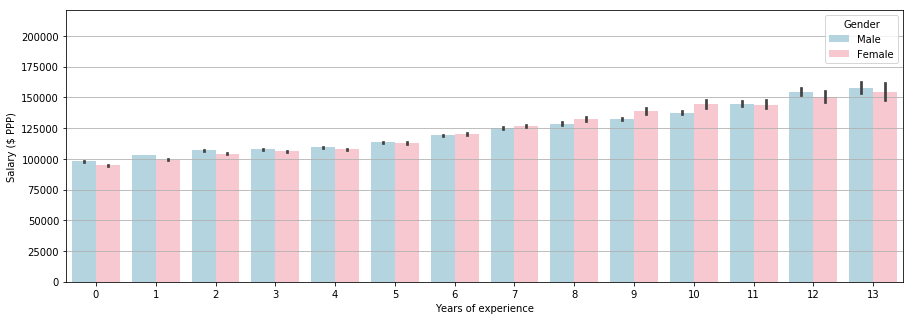

In [43]:
f,ax = plt.subplots(1,1,figsize=(15,5))
ax.grid()
sns.barplot(
    sample.year,
    sample.salary_ppp,
    hue=sample.gender,
    palette = ['lightblue','pink'],
    alpha = 1,
    ax=ax
)
ax.set_xlim((-0.5,13.5))
ax.set_ylabel('Salary ($ PPP)')
ax.set_xlabel('Years of experience')
ax.legend(title='Gender',handles=ax.get_legend_handles_labels()[0],labels=['Male','Female'])

f.savefig('./images/salary.png',dpi=200)

In [72]:
sample.groupby(['year']).gender.value_counts(normalize=True)

year  gender
0     male      0.614065
      female    0.385935
1     male      0.620589
      female    0.379411
2     male      0.634887
      female    0.365113
3     male      0.643732
      female    0.356268
4     male      0.674567
      female    0.325433
5     male      0.704330
      female    0.295670
6     male      0.720949
      female    0.279051
7     male      0.737972
      female    0.262028
8     male      0.757984
      female    0.242016
9     male      0.775843
      female    0.224157
10    male      0.800625
      female    0.199375
11    male      0.852134
      female    0.147866
12    male      0.785425
      female    0.214575
13    male      1.000000
14    male      1.000000
15    male      1.000000
Name: gender, dtype: float64

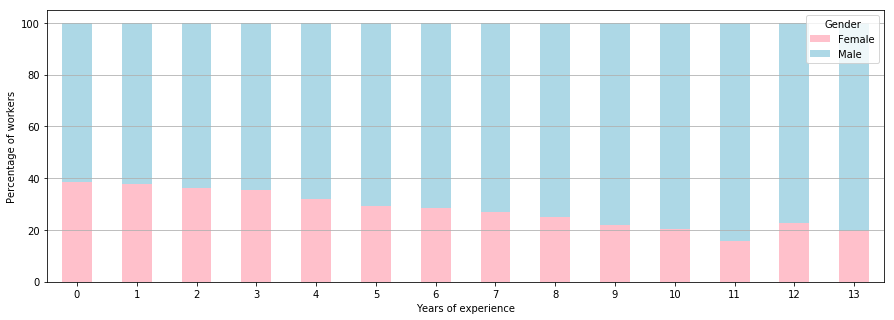

In [91]:
data = sample.groupby(['year']).gender.value_counts(normalize=True).unstack()

f,ax = plt.subplots(1,1,figsize=(15,5))
data.plot.bar(stacked=True,color=['pink','lightblue'],ax=ax)
ax.set_xlim((-0.5,13.5))
ax.set_ylabel('Percentage of workers')
ax.set_xlabel('Years of experience')
plt.xticks(rotation=0)
ax.legend(title='Gender',handles=ax.get_legend_handles_labels()[0],labels=['Female','Male'])
ax.set_yticklabels(range(0,120,20))
ax.grid(axis='y')

f.savefig('./images/proportion.png',dpi=200)